# Developing a Credit Default Model Using Supervised Learning
By Josh Ho

### Project Goal
Develop a credit default model that can predict the probability of a borrower defaulting on a line of credit within 2 years. 

### Steps
1. Load Data
2. Data Preprocessing
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Model Building
6. Model Pipeline
7. Model Evaluation & Tuning
8. Model Deployment

### 1. Load Data

In [31]:
# Import modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [32]:
# Load dataset
credit = pd.read_csv('../data/credit_data.csv')
credit.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [33]:
print(credit.shape)
credit.info()

(150000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  

### 2. Data Preprocessing

Now that we have a loaded our data in and have an idea of what our data looks like, let us perform some preprocessing by cleaning the data. This will focus on using several techniques to prepare it for our model. These techniques include:
- Dropping irrelevant columns
- Handling duplicates
- Imputing nulls
- Renaming columns for interpretability
- Handling outliers

In [34]:
# Drop irrelevant columns
credit = credit.drop(['Unnamed: 0'], axis=1)

In [35]:
credit.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [36]:
# Rename columns for readability
credit.columns = ['Serious_Dlq_in_2yrs', 'Revolving_Utilization_Of_Unsecured_Lines', 'Age',
       'Times_30_Days_Late_Not_Worse', 'Debt_Ratio', 'Monthly_Income',
       'Number_Open_Credit_Lines', 'Times_90_Days_Late',
       'Number_Real_Estate_Loans', 'Times_60_Days_Late_Not_Worse',
       'Number_Dependents']

# Reorder columns
credit = credit[['Age','Monthly_Income','Number_Dependents','Number_Open_Credit_Lines',
       'Number_Real_Estate_Loans','Revolving_Utilization_Of_Unsecured_Lines','Debt_Ratio',
       'Times_30_Days_Late_Not_Worse','Times_60_Days_Late_Not_Worse','Times_90_Days_Late',
       'Serious_Dlq_in_2yrs']]

In [37]:
# Check for duplicates
print(len(credit[credit.duplicated()]), 'Duplicates Found')

# Drop duplicates
credit.drop_duplicates(inplace=True)
print('Dropped 609 Duplicates')

# Confirm removal of duplicates
credit.shape

609 Duplicates Found
Dropped 609 Duplicates


(149391, 11)

In [38]:
# Check for nulls
null = credit.isnull().sum()
check_nulls = pd.DataFrame({"Column": null.index, "Number_Of_Nulls": null.values,
             "Percentage": null.values / len(credit)}).sort_values(by='Number_Of_Nulls', ascending=False).reset_index(drop=True)

check_nulls

,Column,Number_Of_Nulls,Percentage
0,Monthly_Income,29221,0.195601
1,Number_Dependents,3828,0.025624
2,Age,0,0.000000
3,Number_Open_Credit_Lines,0,0.000000
4,Number_Real_Estate_Loans,0,0.000000
5,Revolving_Utilization_Of_Unsecured_Lines,0,0.000000
6,Debt_Ratio,0,0.000000
7,Times_30_Days_Late_Not_Worse,0,0.000000
8,Times_60_Days_Late_Not_Worse,0,0.000000
9,Times_90_Days_Late,0,0.000000


In [39]:
# Significant amount of nulls found in Monthly_Income, impute with median
income_median = credit['Monthly_Income'].median()
print(f'Median of Monthly Income: {income_median}')

credit['Monthly_Income'].fillna(income_median, inplace=True)

Median of Monthly Income: 5400.0


In [40]:
# Significant amount of nulls found in Number_Depedents, impute with mode
dependents_mode = credit['Number_Dependents'].mode(dropna=True)
print(f'Mode of Dependents: {dependents_mode[0]}')

credit['Number_Dependents'].fillna(dependents_mode[0], inplace=True)

Mode of Dependents: 0.0


In [41]:
# Confirm removal of nulls by imputation
credit.isna().sum()

Age                                         0
Monthly_Income                              0
Number_Dependents                           0
Number_Open_Credit_Lines                    0
Number_Real_Estate_Loans                    0
Revolving_Utilization_Of_Unsecured_Lines    0
Debt_Ratio                                  0
Times_30_Days_Late_Not_Worse                0
Times_60_Days_Late_Not_Worse                0
Times_90_Days_Late                          0
Serious_Dlq_in_2yrs                         0
dtype: int64

In [42]:
# Change data types for appropriate columns
credit['Number_Dependents'] = credit['Number_Dependents'].astype('int64')
credit['Monthly_Income'] = credit['Monthly_Income'].astype('int64')

In [43]:
# Check unique values
def unique_values(df):
    columns = df.columns
    for col in columns:
        print('Column:', col)
        print('# of Unique Values:', (len(df[col].unique())))
        print('Unique Values:', df[col].unique())
        print('==============================================================')
    
unique_values(credit)

Column: Age
# of Unique Values: 86
Unique Values: [ 45  40  38  30  49  74  57  39  27  51  46  76  64  78  53  43  25  32
  58  50  69  24  28  62  42  75  26  52  41  81  31  68  70  73  29  55
  35  72  60  67  36  56  37  66  83  34  44  48  61  80  47  59  77  63
  54  33  79  65  86  92  23  87  71  22  90  97  84  82  91  89  85  88
  21  93  96  99  94  95 101  98 103 102 107 105   0 109]
Column: Monthly_Income
# of Unique Values: 13594
Unique Values: [ 9120  2600  3042 ... 15648   521  7647]
Column: Number_Dependents
# of Unique Values: 13
Unique Values: [ 2  1  0  3  4  5  6  8  7 20 10  9 13]
Column: Number_Open_Credit_Lines
# of Unique Values: 58
Unique Values: [13  4  2  5  7  3  8  9  6 10 14 22 17  1 15 31 12 21 11 19 18 26 20 23
  0 16 27 29 28 24 25 32 46 33 30 34 37 38 36 35 54 43 45 49 57 48 40 58
 51 52 39 41 56 42 47 50 44 53]
Column: Number_Real_Estate_Loans
# of Unique Values: 28
Unique Values: [ 6  0  1  3  4  2  5  8  7  9 17 15 10 12 11 16 26 14 54 21 18 13 23

In [44]:
# Check value counts
def value_counts(df):
    columns = df.columns
    for col in columns:
        print('Column:', col)
        print(df[col].value_counts().sort_index())
        print('==============================================================')
    
value_counts(credit)

Column: Age
0        1
21     162
22     368
23     592
24     783
      ... 
102      3
103      3
105      1
107      1
109      2
Name: Age, Length: 86, dtype: int64
Column: Monthly_Income
0          1616
1           596
2             6
4             2
5             2
           ... 
835040        1
1072500       1
1560100       1
1794060       1
3008750       1
Name: Monthly_Income, Length: 13594, dtype: int64
Column: Number_Dependents
0     90220
1     26314
2     19521
3      9483
4      2862
5       746
6       158
7        51
8        24
9         5
10        5
13        1
20        1
Name: Number_Dependents, dtype: int64
Column: Number_Open_Credit_Lines
0      1712
1      4251
2      6558
3      8992
4     11566
5     12916
6     13607
7     13242
8     12559
9     11355
10     9623
11     8321
12     7005
13     5667
14     4546
15     3645
16     3000
17     2370
18     1874
19     1433
20     1169
21      864
22      685
23      533
24      422
25      337
26      239
27   

#### Handling Outliers with Descriptive Statistics

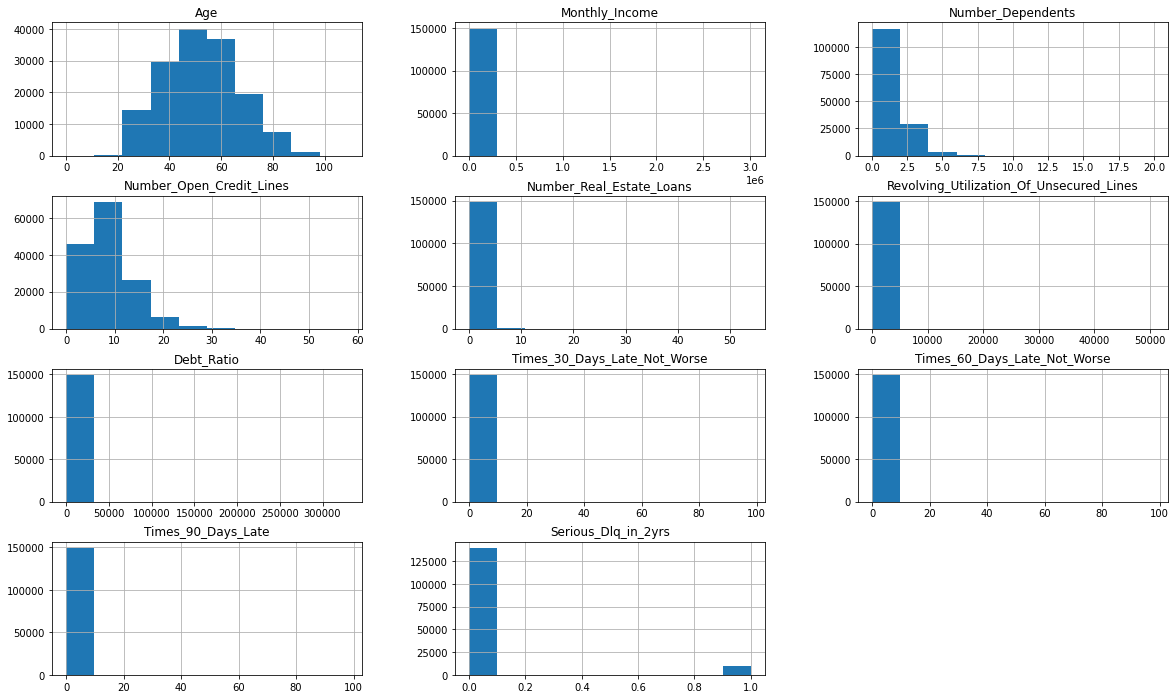

In [45]:
# Visualize descriptive statistics
credit.hist(figsize=(20,12));

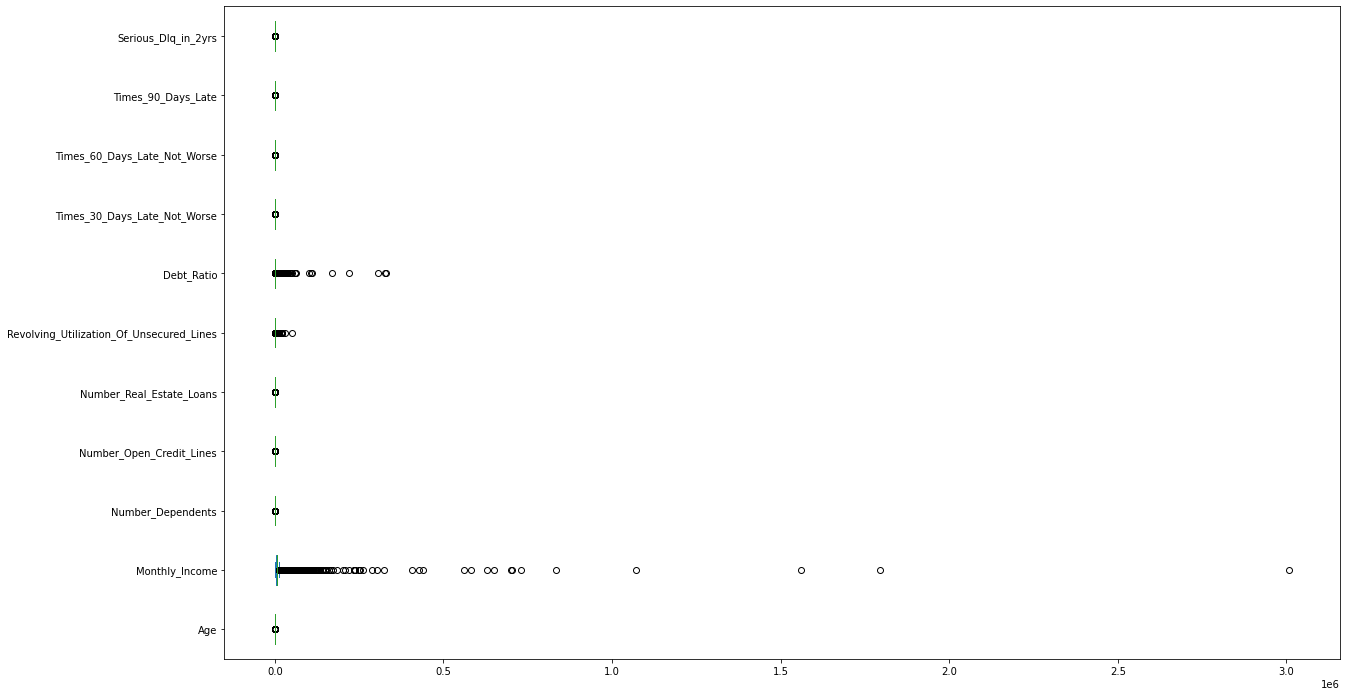

In [46]:
# Check for outliers 
credit.plot.box(figsize=(20,12), vert=False);

In [47]:
# Check descriptive statistics
credit.describe()

,Age,Monthly_Income,Number_Dependents,Number_Open_Credit_Lines,Number_Real_Estate_Loans,Revolving_Utilization_Of_Unsecured_Lines,Debt_Ratio,Times_30_Days_Late_Not_Worse,Times_60_Days_Late_Not_Worse,Times_90_Days_Late,Serious_Dlq_in_2yrs
count,149391.000000,1.493910e+05,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000,149391.000000
mean,52.306237,6.425688e+03,0.740393,8.480892,1.022391,6.071087,354.436740,0.393886,0.212503,0.238120,0.066999
std,14.725962,1.291567e+04,1.108272,5.136515,1.130196,250.263672,2041.843455,3.852953,3.810523,3.826165,0.250021
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,3.900000e+03,0.000000,5.000000,0.000000,0.030132,0.177441,0.000000,0.000000,0.000000,0.000000
50%,52.000000,5.400000e+03,0.000000,8.000000,1.000000,0.154235,0.368234,0.000000,0.000000,0.000000,0.000000
75%,63.000000,7.400000e+03,1.000000,11.000000,2.000000,0.556494,0.875279,0.000000,0.000000,0.000000,0.000000
max,109.000000,3.008750e+06,20.000000,58.000000,54.000000,50708.000000,329664.000000,98.000000,98.000000,98.000000,1.000000


Looking at the statistical description of the dataset and seeing each columns unique value count, 5 columns have noticeable outliers:
- Revolving Utilization of Unsecured Lines
- Debt Ratio
- Times 30 Days Late
- Times 60 Days Late
- Times 90 Days Late

Let's drill down into them and address them.

In [48]:
# Revolving Utlization of Unsecured Lines
# This value should not be significantly larger then 1, so a value of 50708 is clearly an outlier
# As a baseline, let's remove values that are above 10 as it will skew our dataset 
credit.drop(credit[credit['Revolving_Utilization_Of_Unsecured_Lines'] > 10].index, inplace=True)

In [49]:
# Confirm changes
print(credit.shape)
credit[['Revolving_Utilization_Of_Unsecured_Lines']].describe()

(149150, 11)


,Revolving_Utilization_Of_Unsecured_Lines
count,149150.000000
mean,0.322065
std,0.365943
min,0.000000
25%,0.030027
50%,0.153564
75%,0.553558
max,8.851852


In [50]:
# Debt Ratio
# The max value for debt ratio is 329664, which means this individual owes a shocking amount of money in proportion to their assets
# This will be treated as an outlier, and we will remove anything above the 98th percentile as it could skew the dataset
credit['Debt_Ratio'].quantile([.98])

0.98    3841.0
Name: Debt_Ratio, dtype: float64

In [51]:
# Drop values greater than or equal to 98th quantile
credit.drop(credit[credit['Debt_Ratio'] >= 3481].index, inplace=True)

In [52]:
# Confirm changes
print(credit.shape)
credit[['Debt_Ratio']].describe()

(145388, 11)


,Debt_Ratio
count,145388.000000
mean,210.537367
std,620.093706
min,0.000000
25%,0.172147
50%,0.357529
75%,0.761138
max,3480.000000


In [53]:
# Looking at our value counts for the 3 columns pertaining to 30, 60, and 90 days late, we can see they have interesting 96 and 98 values that occur at 5 and 220 times each
# The distribution is a clear outlier, as their deviation from the rest of the values are very far
# To account for this, we will simply replace these values with the 3rd largest value prior to the 96/98 values as to not greatly skew the dataset from what could be an entry error

credit.loc[credit['Times_30_Days_Late_Not_Worse'] >= 96, 'Times_30_Days_Late_Not_Worse'] = 13
credit.loc[credit['Times_60_Days_Late_Not_Worse'] >= 96, 'Times_60_Days_Late_Not_Worse'] = 11
credit.loc[credit['Times_90_Days_Late'] >= 96, 'Times_90_Days_Late'] = 17

In [54]:
# Confirm changes
print(credit.shape)
credit[['Times_30_Days_Late_Not_Worse','Times_60_Days_Late_Not_Worse','Times_90_Days_Late' ]].describe()

(145388, 11)


,Times_30_Days_Late_Not_Worse,Times_60_Days_Late_Not_Worse,Times_90_Days_Late
count,145388.000000,145388.000000,145388.000000
mean,0.265180,0.082235,0.117878
std,0.857581,0.542338,0.824507
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,13.000000,11.000000,17.000000


In [55]:
# Export cleaned DataFrame to csv
credit.to_csv('../data/credit_c.csv', index=False)

### 3. EDA

We can visualize the statistics of the dataset using histograms and bar graphs to help interpret the data. We can conduct analysis on statistics such as:
- The balance of classes
- The distribution of ages that did not default
- The distribution of ages that did default
- Number of children
- Number of real estate loans
- Number of credit lines
- Total number of debt accounts opened

#### Balance of Classes

Percent of Inviduals Who Defaulted: 0.0671%


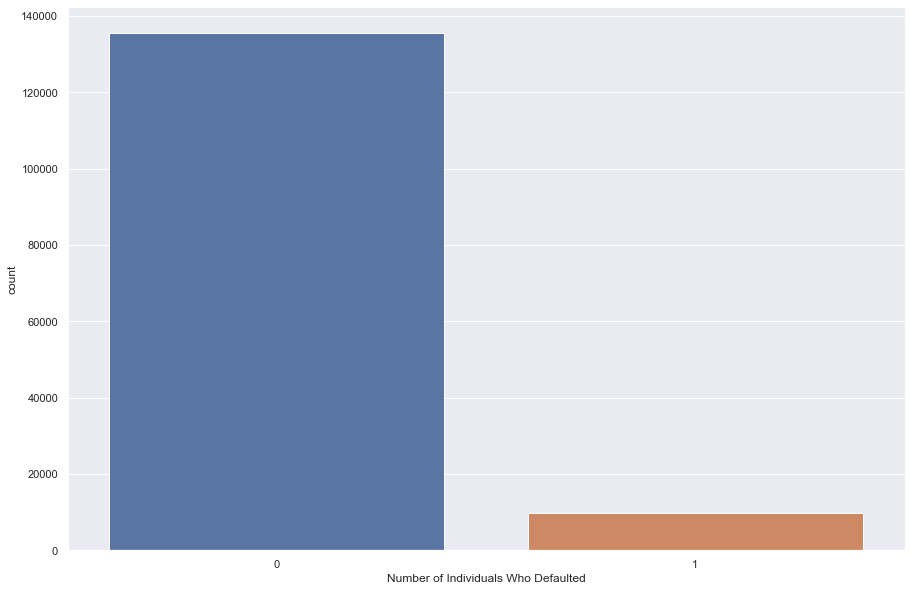

In [56]:
sns.set(rc={'figure.figsize':(15,10)}) # Set figure size

plot = sns.countplot(x=credit['Serious_Dlq_in_2yrs'], data=credit)
plot.set(xlabel='Number of Individuals Who Defaulted')

default = round(credit.Serious_Dlq_in_2yrs.sum()/len(credit), 4)
print(f'Percent of Inviduals Who Defaulted: {default}%')

#### Distribution of Ages That Did Not Default

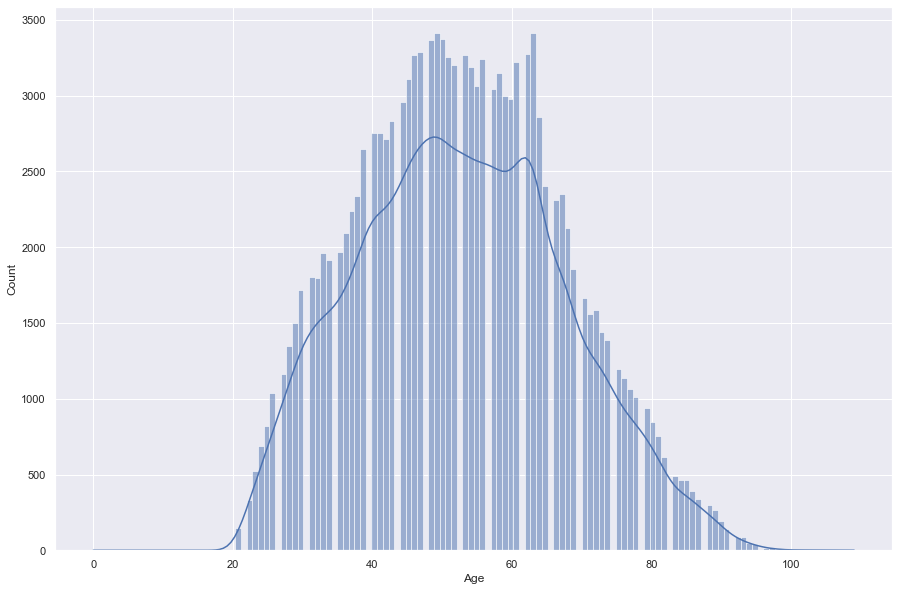

In [57]:
sns.histplot(credit.loc[credit['Serious_Dlq_in_2yrs'] == 0]["Age"], kde=True);

#### Distribution of Ages That Did Default

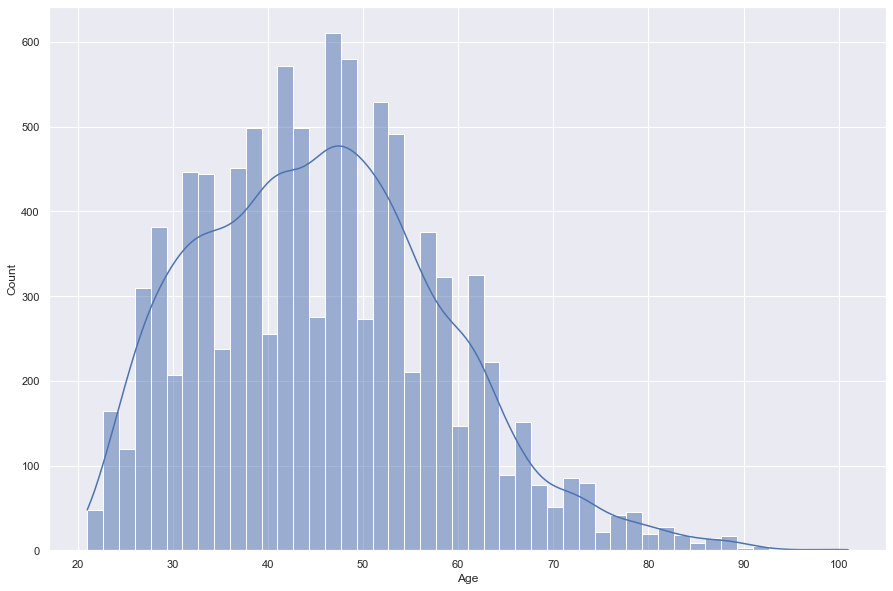

In [58]:
sns.histplot(credit.loc[credit['Serious_Dlq_in_2yrs'] == 1]["Age"], kde=True);

#### Number of Children

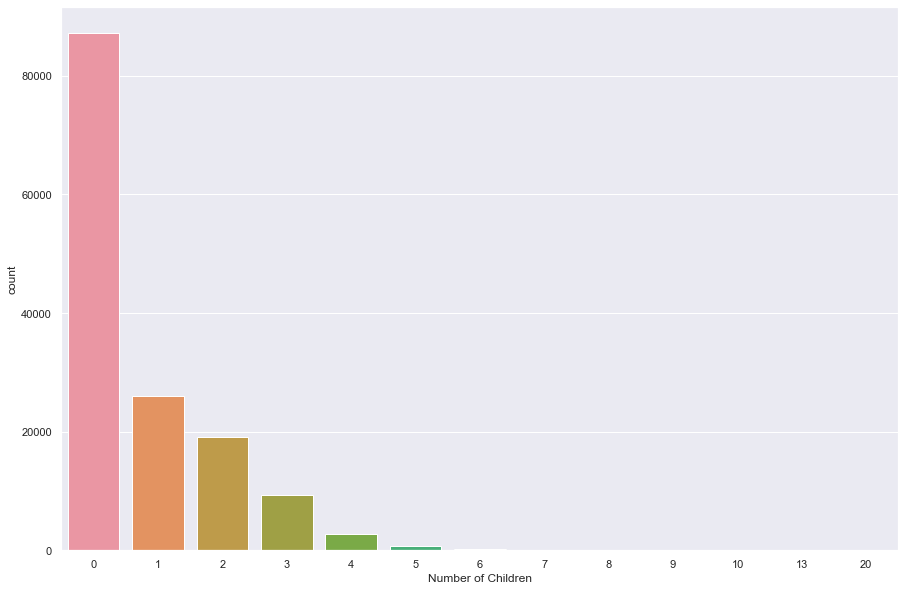

In [59]:
plot = sns.countplot(x=credit['Number_Dependents'], data=credit)
plot.set(xlabel='Number of Children');

#### Number of Real Estate Loans

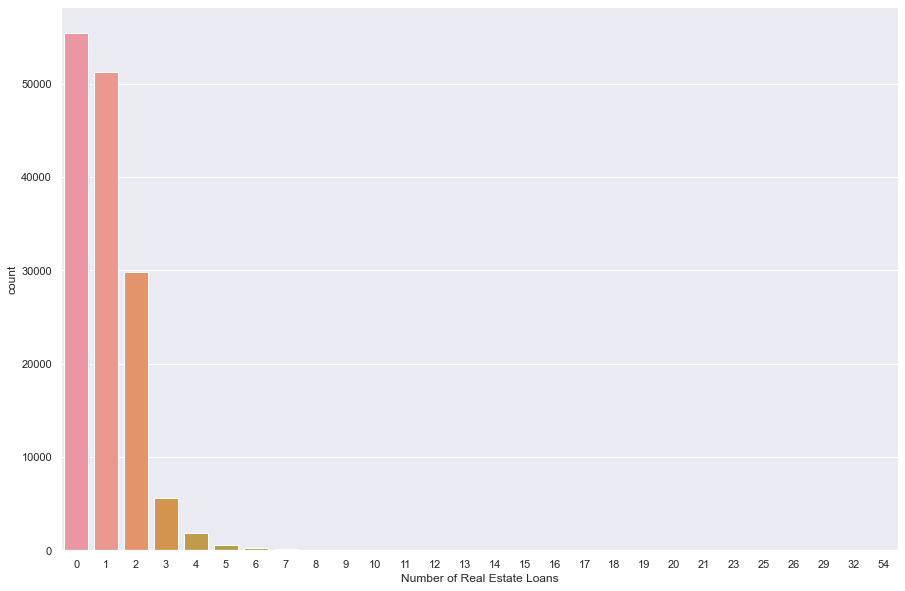

In [60]:
plot = sns.countplot(x=credit['Number_Real_Estate_Loans'], data=credit)
plot.set(xlabel='Number of Real Estate Loans');

#### Number of Credit Lines Opened

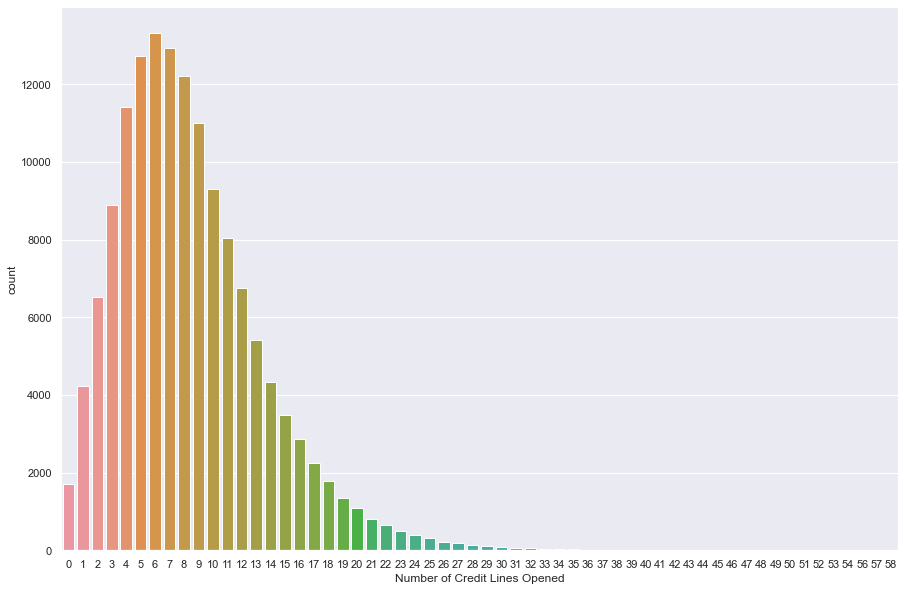

In [61]:
plot = sns.countplot(x=credit['Number_Open_Credit_Lines'], data=credit)
plot.set(xlabel='Number of Credit Lines Opened');

#### Total Number of Debt Accounts Opened

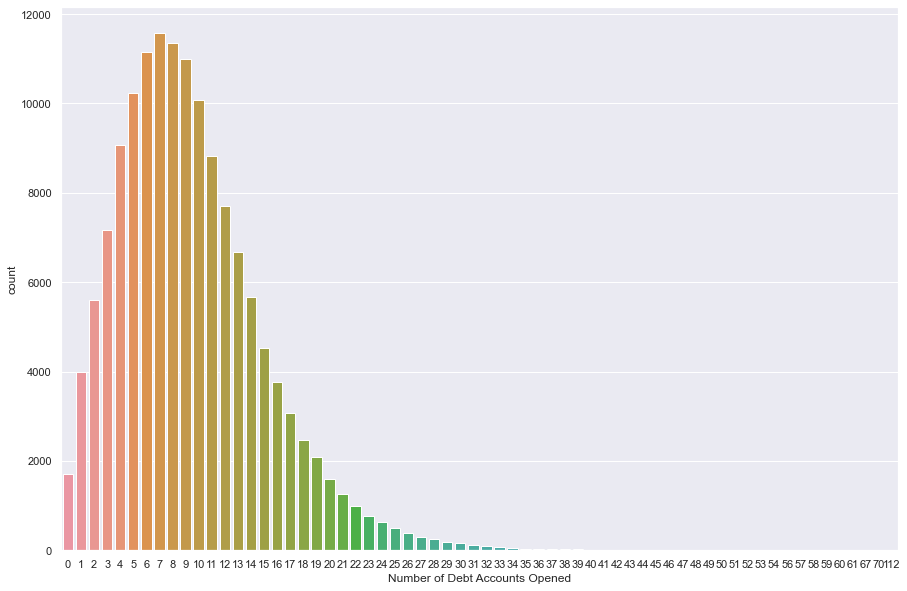

In [62]:
plot = sns.countplot(x=credit['Number_Open_Credit_Lines']+credit['Number_Real_Estate_Loans'], data=credit)
plot.set(xlabel='Number of Debt Accounts Opened');

### 4. Feature Engineering

For feature engineering, we simple scale our numeric features, except the target variable with the MinMax scaler. This will help normalize the data and prepare it for our modeling steps.

In [63]:
# Scale all numeric features, except the target variable
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
credit_scaled = pd.DataFrame(scaler.fit_transform(credit.iloc[:,0:-1]), columns=credit.iloc[:,0:-1].columns)

### 5. Model Building

For our modeling portion, we will isolate and scale the numeric features, then feed the data into 5 different classifiers:
- Logistic Regression
- K-Nearest Neighbor
- Naive Bayes 
- Random Forest
- XGBoost

To evaluate our models, we will use:
- K-Folds Cross Validation
- ROC AUC Score

In [64]:
# Import modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pickle as pkl

In [65]:
# Isolate target variable and separate independent variables
X = credit_scaled
y = credit.iloc[:,-1]

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X training shape:", X_train.shape)
print("X test shape:", X_test.shape)
print("y training shape:", y_train.shape)
print("y test shape:", y_test.shape)

X training shape: (116310, 10)
X test shape: (29078, 10)
y training shape: (116310,)
y test shape: (29078,)


#### Model Baselines
Let's first set and look at our models baselines, checking for model performance without any hyperparameter tuning.

In [66]:
def classifiers():
    clfs = []
    clfs.append(('LR', LogisticRegression()))
    clfs.append(('KN', KNeighborsClassifier()))
    clfs.append(('NB', GaussianNB()))
    clfs.append(('RF', RandomForestClassifier()))
    clfs.append(('XG', XGBClassifier()))

    return clfs

In [67]:
def baseline_evaluation(X_train, y_train,models):
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=5)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        
    return names, results

In [68]:
def score_df(names,results):
    def floating_decimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floating_decimals(r.mean(),4)*100)

    score_df = pd.DataFrame({'Model':names, 'Score': scores})
    return score_df

In [69]:
models = classifiers()
names, results = baseline_evaluation(X_train, y_train, models)
baseline_scores = score_df(names, results)
baseline_scores

,Model,Score
0,LR,84.61
1,KN,73.45
2,NB,84.23
3,RF,84.10
4,XG,85.92


#### Model Pipeline & Optimization
Now that we have our baselines, let's set up our pipeline to make our machine learning process more efficient. Further more we will set up multiple hyperparameters for the 5 classifers we are using, then plug both the pipeline and the list of hyperparameters into GridSearch for optimization.

In [70]:
# Initiaze the classifiers and hyperparameters for each dictionary

clf1 = RandomForestClassifier()
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

clf2 = LogisticRegression()
param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__penalty'] = ['l2', 'none']
param2['classifier__solver'] = ['newton-cg', 'lbfgs', 'sag']
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

clf3 = KNeighborsClassifier()
param3 = {}
param3['classifier__n_neighbors'] = [2, 5, 10, 25, 50]
param3['classifier__p'] = [1, 2]
param3['classifier__leaf_size'] = [1, 5, 10, 15]
param3['classifier'] = [clf3]

clf4 = MultinomialNB()
param4 = {}
param4['classifier__alpha'] = [10**0, 10**1, 10**2]
param4['classifier'] = [clf4]

clf7 = XGBClassifier()
param5 = {}
param5['classifier__min_child_weight'] = [1, 5, 10]
param5['classifier__gamma'] = [0.5, 1, 1.5, 2, 5]
param5['classifier__subsample'] = [0.6, 0.8, 1.0]
param5['classifier__colsample_bytree'] = [0.6, 0.8, 1.0]
param5['classifier__max_depth'] = [3, 4, 5]
param5['classifier'] = [clf7]   

params = [param1, param2, param3, param4, param5]

In [71]:
# Create pipeline
pipeline = Pipeline([('classifier', clf1)])

In [72]:
# Execute grid search on pipeline (17m01s)
grid = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='roc_auc', verbose=3)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 616 candidates, totalling 1848 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [RandomForestClassifier()],
                          'classifier__class_weight': [None, {0: 1, 1: 5},
                                                       {0: 1, 1: 10},
                                                       {0: 1, 1: 25}],
                          'classifier__max_depth': [5, 10, 20],
                          'classifier__n_estimators': [10, 50, 100, 250]},
                         {'classifier': [LogisticRegression()],
                          'classifier__C': [0.0...
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       predictor=None,
                                                       random_state=None, ...)],
                          'classifier__colsample_bytree': [0.6, 0.8, 1.0],
                          'classifier__gamma': [0.5, 1, 1.5, 2, 5],
                          'classifier__max_depth': [3, 4, 5],
                          'classifier__min_child_weight': [1, 5, 10],
                          'classifier__subsample': [0.6, 0.8, 1.0]}],
             scoring='roc_auc', verbose=3)

In [73]:
# Grid search results to DataFrame
pd.DataFrame(data=grid.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__class_weight,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__C,param_classifier__penalty,...,param_classifier__gamma,param_classifier__min_child_weight,param_classifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.189468,0.058131,0.060721,0.004722,RandomForestClassifier(),None,5,10,NaN,NaN,...,NaN,NaN,NaN,"{'classifier': RandomForestClassifier(), 'clas...",0.859534,0.853267,0.858090,0.856964,0.002679,424
1,4.836651,0.232580,0.200209,0.008540,RandomForestClassifier(),None,5,50,NaN,NaN,...,NaN,NaN,NaN,"{'classifier': RandomForestClassifier(), 'clas...",0.865825,0.856697,0.859441,0.860654,0.003824,317
2,11.877803,1.857173,0.441514,0.019831,RandomForestClassifier(),None,5,100,NaN,NaN,...,NaN,NaN,NaN,"{'classifier': RandomForestClassifier(), 'clas...",0.864479,0.856549,0.859888,0.860305,0.003251,331
3,30.684040,6.451253,1.255686,0.271414,RandomForestClassifier(),None,5,250,NaN,NaN,...,NaN,NaN,NaN,"{'classifier': RandomForestClassifier(), 'clas...",0.865131,0.857441,0.860036,0.860869,0.003194,300
4,1.795818,0.060926,0.078216,0.002042,RandomForestClassifier(),None,10,10,NaN,NaN,...,NaN,NaN,NaN,"{'classifier': RandomForestClassifier(), 'clas...",0.865649,0.859037,0.859052,0.861246,0.003114,284


In [74]:
# Access the best set of parameters
best_params = grid.best_params_
print('Best Parameters \n======================================')
print(best_params, '\n')

# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print('Best Pipeline \n======================================')
print(best_pipe, '\n')

# Best score for the best model
best_score = grid.best_score_
print('Best Score \n======================================')
print(f'Score: {round(best_score, 4) * 100}%')

Best Parameters 
{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), 'classifier__colsample_bytree': 0.6, 'classifier__gamma': 5, 'classifier__max_depth': 3, 'classifier__min_child_weight': 5, 'classifier__subsample': 1.0} 

Best Pipeline 
Pipeline(steps=[('classifier',
                 XGBCla

With the use of GridSearch, and our classifier pipeline, we were able to score 664 candidates, totalling 1992 fits. Allowing us to find the best model and hyperparameters to use, as well as the best score achieved. Which were:
- XGBoost (colsample_bytree': 0.8, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0)
- Wth a train score of 86.58%!

We will now use this model for deployment and push it to cloud for user predictions.

### 8. Model Deployment

Below is the pipeline we will persist and use for deployment using Flask and AWS. We can also ensure the pipeline is correct when pickled, and test our model with some sample predictions.

In [75]:
import pandas as pd
import numpy as np
import pickle as pkl
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Load data
credit = pd.read_csv('../data/credit_c.csv')

# Create train and test sets
X = credit.iloc[:,0:-1]
y = credit.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Set pipeline parameters
scaler = MinMaxScaler()
clf = XGBClassifier(colsample_bytree= 0.8, gamma= 5, 
                    max_depth= 3, min_child_weight= 1, 
                    subsample= 1.0)

# Create pipeline
pipe = Pipeline(steps=[
                ('scaler', scaler),
                ('classifier', clf) 
                ])

# Fit pipeline
pipe.fit(X_train, y_train)

# Save pipe to disk
pkl.dump(pipe, open('../app/pipe.pkl','wb'))

# Load pipe from disk
pipe = pkl.load(open('../app/pipe.pkl', 'rb'))
pipe

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=5, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=3, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

### Pipeline Sample Prediction Testing

In [79]:
# Predict 200 samples of test data with pickled pipeline
y_pred = pipe.predict(X_test)
predictions = [round(value) for value in y_pred]
print(predictions[0:200])

# Positive target variable result - will likely default
values = np.array([[37.0, 2925.0, 0.0, 4.0, 1.0, 1.12, 0.48, 1.0, 1.0, 3.0]])
data = pd.DataFrame(data=values, columns=X_test.columns)
pred = pipe.predict(data)
print(pred[0])

# Negative target variable result - will likely not default
values = np.array([[59.0, 4500.0, 0.0, 11.0, 2.0, 0.75, 0.21, 2.0, 0.0, 1.0]])
data = pd.DataFrame(data=values, columns=X_test.columns)
pred = pipe.predict(data)
pred[0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1


0